In [ ]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip

# Define paths

In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Eye_Disease/dataset")
data = image_dataset_from_directory(data_dir, seed = 123, image_size=(224, 224))
class_names = data.class_names

Found 4247 files belonging to 4 classes.


<Axes: >

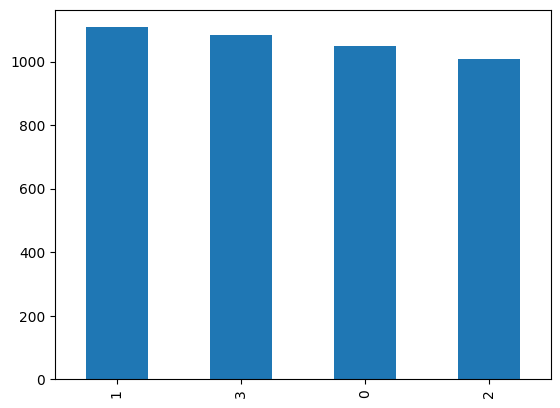

In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values.plot(kind='bar')

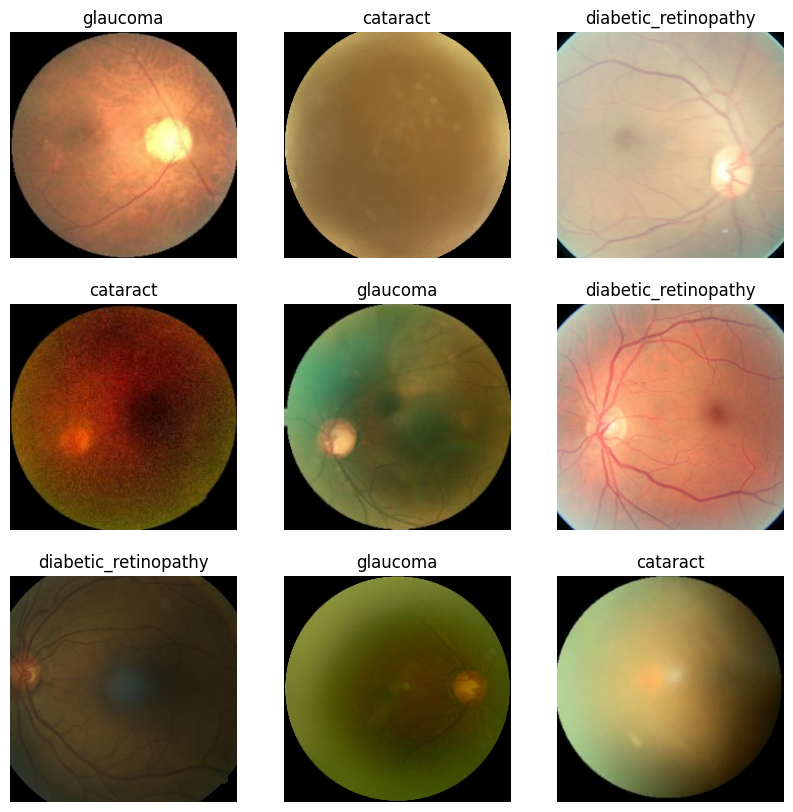

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")

In [ ]:
data = data.map(lambda x, y: (x/255, y))
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [ ]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

In [ ]:
def evaluate_model(model):
    model.evaluate(test)
    y_pred = np.argmax(model.predict(test_set['images']), 1)
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

In [ ]:
model = Sequential([
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     147584    
                                                        

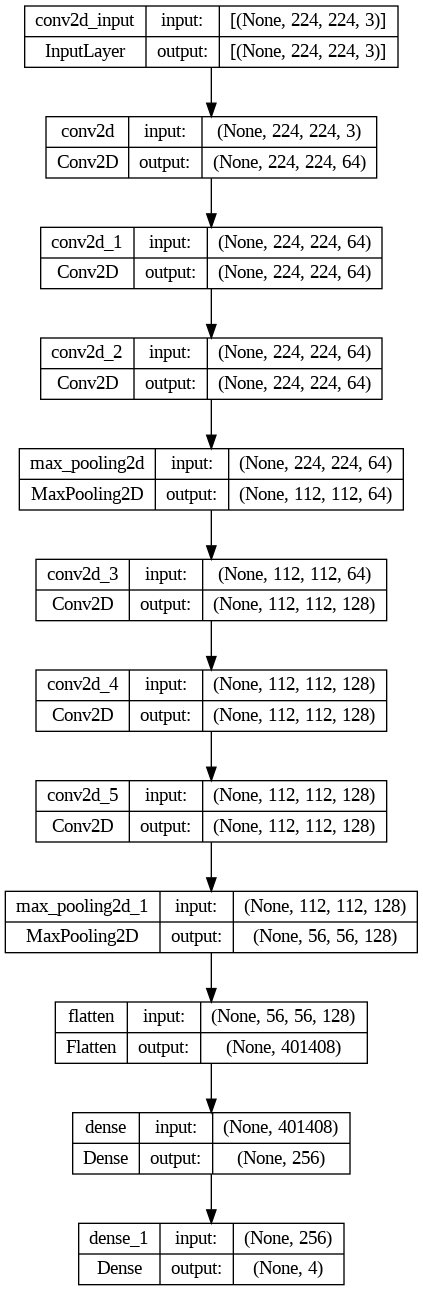

In [ ]:
plot_model(model, to_file='simple-cnn.png', show_shapes=True)

In [ ]:
history = model.fit(train, validation_data=val, epochs = 10)


Epoch 1/10
94/94 [==============================] - 79s 797ms/step - loss: 1.1677 - accuracy: 0.4621 - val_loss: 0.8227 - val_accuracy: 0.6166
Epoch 2/10
94/94 [==============================] - 75s 789ms/step - loss: 0.8046 - accuracy: 0.6230 - val_loss: 0.6952 - val_accuracy: 0.7019
Epoch 3/10
94/94 [==============================] - 76s 799ms/step - loss: 0.6734 - accuracy: 0.6995 - val_loss: 0.6559 - val_accuracy: 0.6947
Epoch 4/10
94/94 [==============================] - 76s 792ms/step - loss: 0.5866 - accuracy: 0.7437 - val_loss: 0.5875 - val_accuracy: 0.7584
Epoch 5/10
94/94 [==============================] - 76s 792ms/step - loss: 0.5491 - accuracy: 0.7630 - val_loss: 0.5586 - val_accuracy: 0.7812
Epoch 6/10
94/94 [==============================] - 76s 800ms/step - loss: 0.5040 - accuracy: 0.7869 - val_loss: 0.5077 - val_accuracy: 0.8125
Epoch 7/10
94/94 [==============================] - 76s 796ms/step - loss: 0.4734 - accuracy: 0.7985 - val_loss: 0.5304 - val_accuracy: 0.8125

In [ ]:
def plot_performance(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

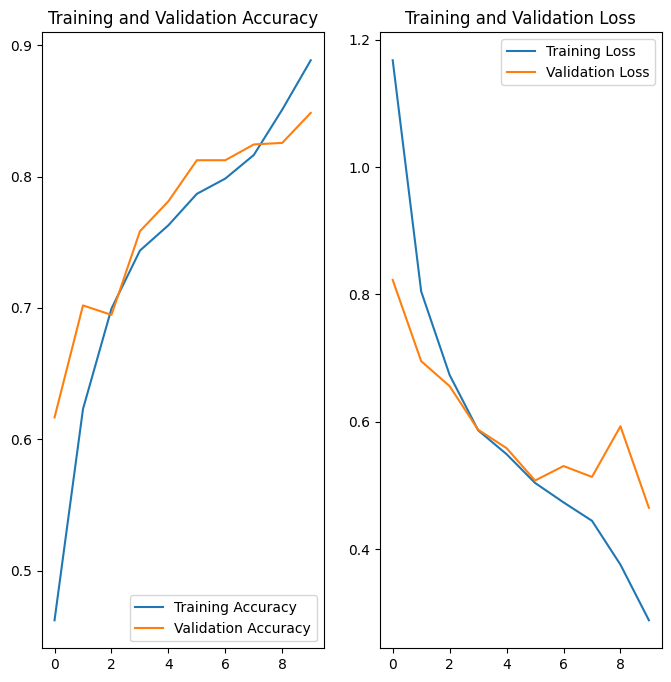

In [ ]:
plot_performance(10, history)

13/13 [==============================] - 1s 98ms/step
                      precision    recall  f1-score   support

            cataract       0.72      0.92      0.81        90
diabetic_retinopathy       1.00      1.00      1.00       108
            glaucoma       0.95      0.50      0.66       105
              normal       0.79      0.96      0.87       104

            accuracy                           0.85       407
           macro avg       0.86      0.85      0.83       407
        weighted avg       0.87      0.85      0.83       407



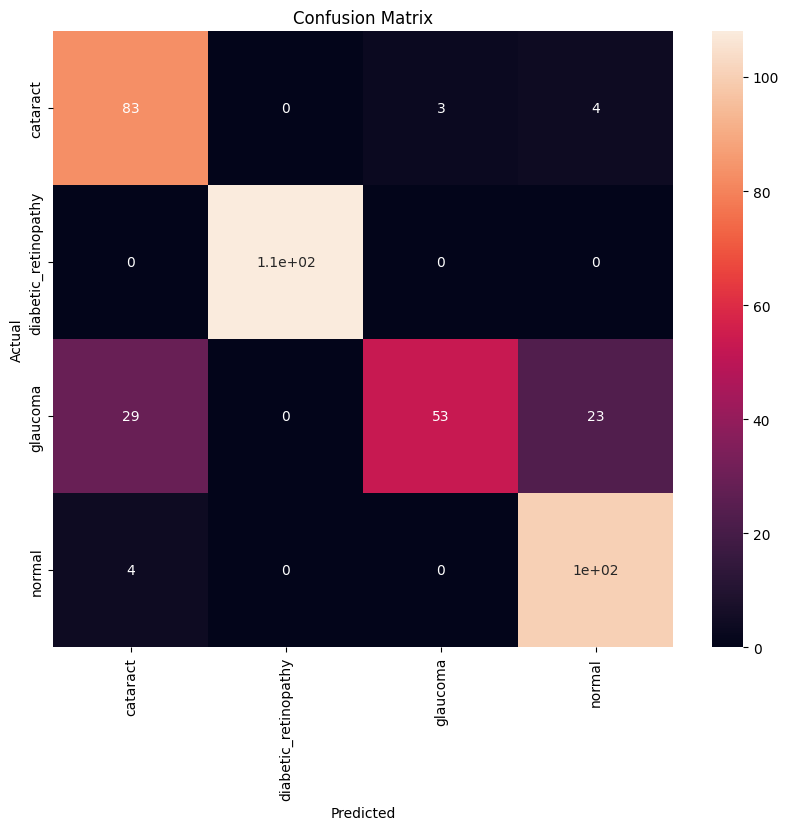

In [ ]:
evaluate_model(model)


In [ ]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a079aa7382d10e3aa32b7e75877fe0685ff20d6c6e524f262ce46b933048f437
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage.transform import resize

def predict_image(image_path):
    img = imread(image_path)
    img = resize(img, (224,224))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    prediction = np.argmax(preds)
    pct = np.max(preds)
    if prediction == 0:
        print('Cataract')
    elif prediction == 1:
        print('Diabetic retinopathy')
    elif prediction == 2:
        print('Glaucoma')
    else:
        print('Normal')
    print(pct)
    return img

In [ ]:
def explain_prediction(image_path):
    img = predict_image(image_path)
    explainer = lime_image.LimeImageExplainer(random_state=12)
    explanation = explainer.explain_instance(
             img[0].astype('double'),
             model.predict
    )
    from skimage.segmentation import mark_boundaries

    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

In [ ]:
explain_prediction("/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/1196_left.jpeg")

In [ ]:
explain_prediction("/kaggle/input/eye-diseases-classification/dataset/glaucoma/1389_right.jpg")

In [ ]:
explain_prediction("/kaggle/input/eye-diseases-classification/dataset/cataract/103_left.jpg")

DATA AUGMENTATION

In [ ]:
data_augmentation = Sequential([
    RandomContrast(0.4),
    RandomZoom(0.2, fill_mode="constant")
])

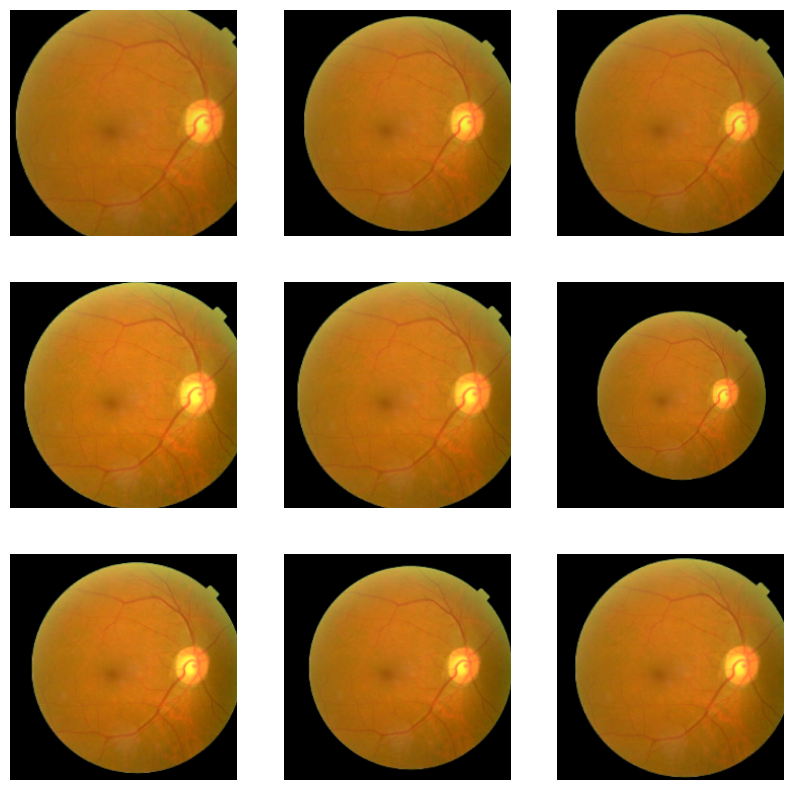

In [ ]:
i = 0
for images, labels in train.take(1):
    image = tf.cast(tf.expand_dims(images[i].numpy(), 0), tf.float32)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = data_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.axis("off")
    break

In [ ]:
model = Sequential([
        data_augmentation,
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train, validation_data=val, epochs = 10)

Epoch 1/10
94/94 [==============================] - 79s 815ms/step - loss: 1.5406 - accuracy: 0.3657 - val_loss: 1.1799 - val_accuracy: 0.4507
Epoch 2/10
94/94 [==============================] - 78s 814ms/step - loss: 1.1681 - accuracy: 0.4721 - val_loss: 1.1161 - val_accuracy: 0.5048
Epoch 3/10
94/94 [==============================] - 76s 793ms/step - loss: 1.0597 - accuracy: 0.5189 - val_loss: 1.0660 - val_accuracy: 0.5300
Epoch 4/10
94/94 [==============================] - 76s 800ms/step - loss: 1.0051 - accuracy: 0.5615 - val_loss: 0.9889 - val_accuracy: 0.5228
Epoch 5/10
94/94 [==============================] - 77s 807ms/step - loss: 0.9936 - accuracy: 0.5768 - val_loss: 0.9913 - val_accuracy: 0.5625
Epoch 6/10
94/94 [==============================] - 76s 794ms/step - loss: 0.9543 - accuracy: 0.5874 - val_loss: 1.0255 - val_accuracy: 0.5709
Epoch 7/10
94/94 [==============================] - 77s 795ms/step - loss: 0.8956 - accuracy: 0.6277 - val_loss: 0.8789 - val_accuracy: 0.5974

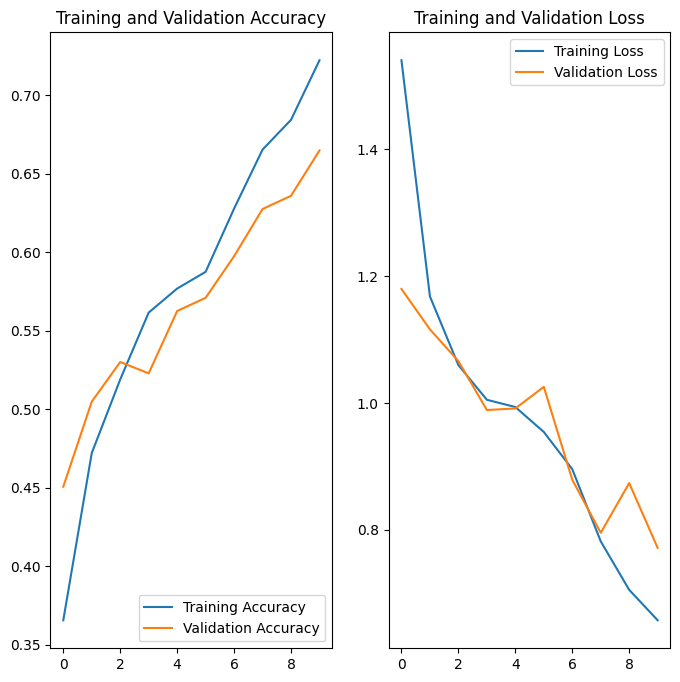

In [ ]:
plot_performance(10, history)

13/13 [==============================] - 1s 90ms/step
                      precision    recall  f1-score   support

            cataract       0.80      0.50      0.62        90
diabetic_retinopathy       0.96      0.95      0.96       108
            glaucoma       0.69      0.38      0.49       105
              normal       0.50      0.89      0.64       104

            accuracy                           0.69       407
           macro avg       0.74      0.68      0.68       407
        weighted avg       0.74      0.69      0.68       407



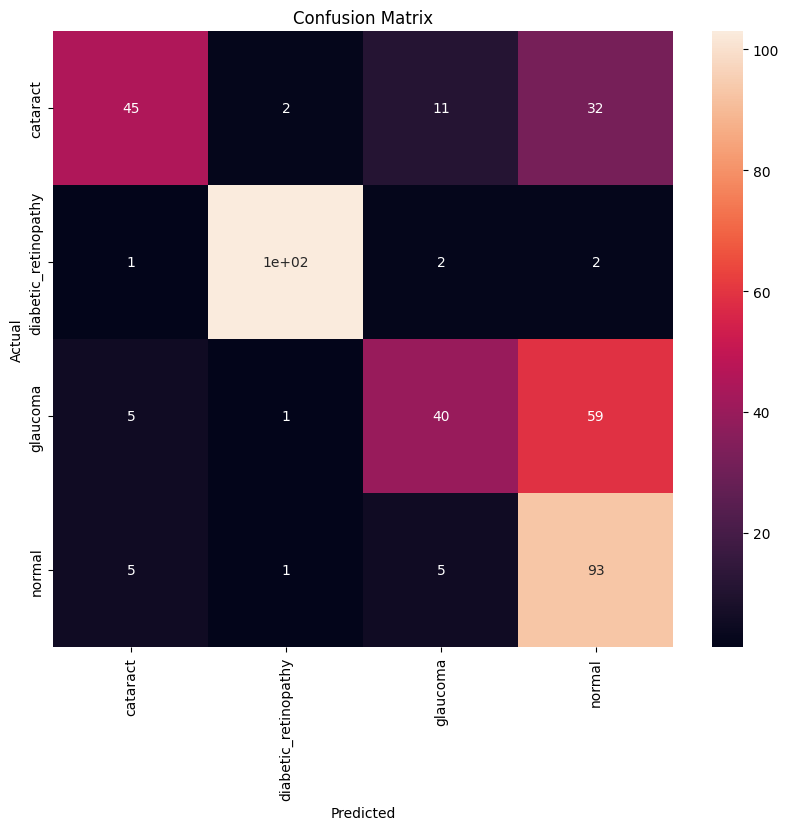

In [ ]:
evaluate_model(model)

TRANSFER LEARNING


DensetNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))
for layer in dense.layers[:121]:
    layer.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
model = Sequential([
    dense,
    MaxPool2D(2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 1024)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 1024)        0         
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1179776   
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                      

In [ ]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
94/94 [==============================] - 112s 684ms/step - loss: 0.8650 - accuracy: 0.7929 - val_loss: 3.1497 - val_accuracy: 0.7752
Epoch 2/10
94/94 [==============================] - 72s 750ms/step - loss: 0.2678 - accuracy: 0.8983 - val_loss: 0.3075 - val_accuracy: 0.9111
Epoch 3/10
94/94 [==============================] - 71s 748ms/step - loss: 0.2048 - accuracy: 0.9255 - val_loss: 0.2475 - val_accuracy: 0.9147
Epoch 4/10
94/94 [==============================] - 72s 751ms/step - loss: 0.1661 - accuracy: 0.9358 - val_loss: 0.4897 - val_accuracy: 0.8930
Epoch 5/10
94/94 [==============================] - 72s 751ms/step - loss: 0.1367 - accuracy: 0.9538 - val_loss: 0.4358 - val_accuracy: 0.8702
Epoch 6/10
94/94 [==============================] - 71s 747ms/step - loss: 0.1294 - accuracy: 0.9501 - val_loss: 1.0583 - val_accuracy: 0.8269
Epoch 7/10
94/94 [==============================] - 71s 749ms/step - loss: 0.1269 - accuracy: 0.9608 - val_loss: 0.5196 - val_accuracy: 0.853

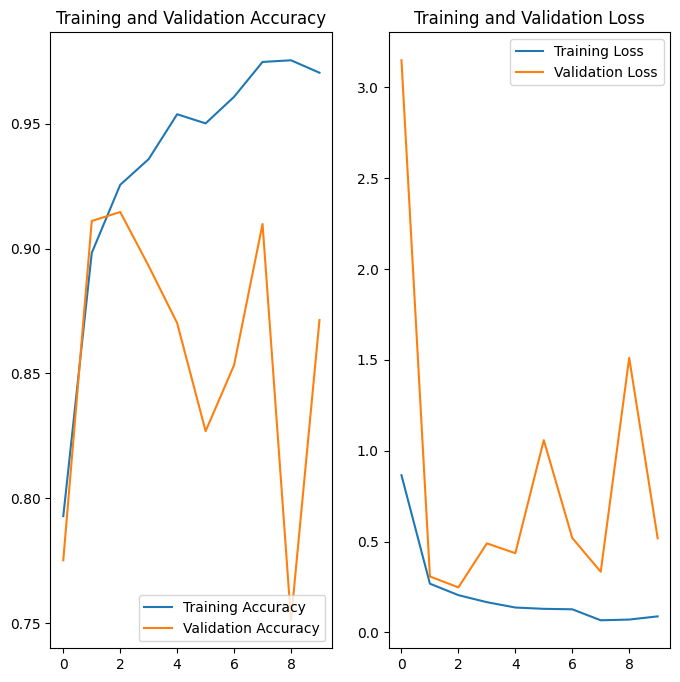

In [ ]:
plot_performance(10, history)

13/13 [==============================] - 3s 98ms/step
                      precision    recall  f1-score   support

            cataract       0.98      0.88      0.92        90
diabetic_retinopathy       0.99      0.99      0.99       108
            glaucoma       0.65      0.96      0.77       105
              normal       0.90      0.54      0.67       104

            accuracy                           0.84       407
           macro avg       0.88      0.84      0.84       407
        weighted avg       0.88      0.84      0.84       407



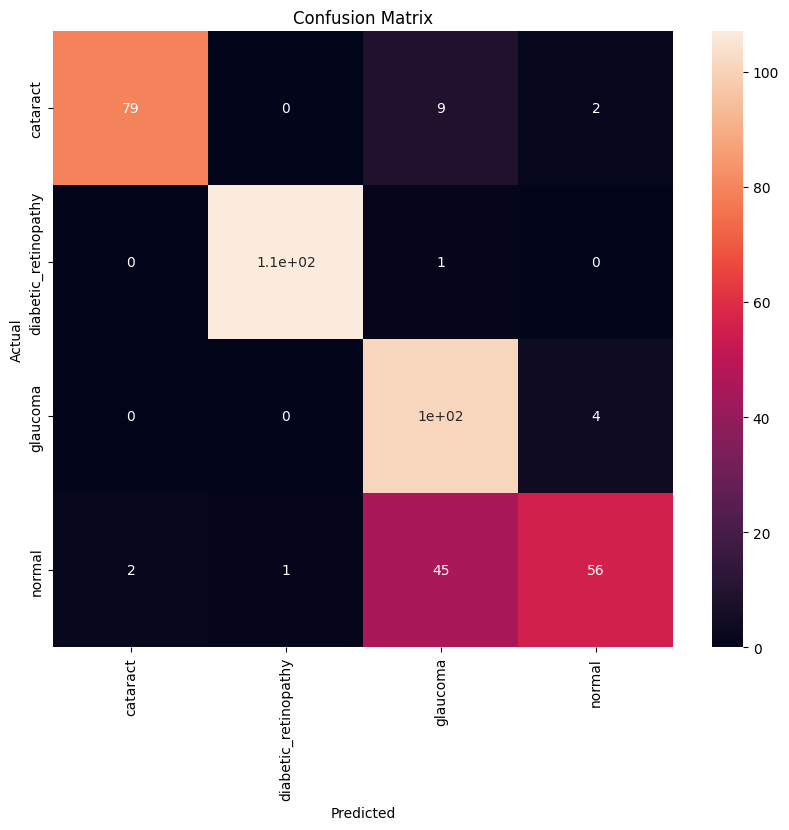

In [ ]:
evaluate_model(model)

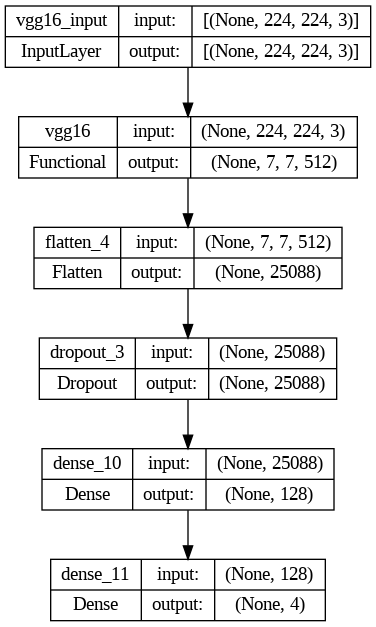

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='densenet.png', show_shapes=True)

EfficientNet

In [ ]:
from keras.applications.efficientnet import EfficientNetB0
effnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling='max')
effnet.trainable = False
for layer in effnet.layers[83:]:
    layer.trainable = True

In [ ]:
model = Sequential([
    effnet,
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 512)               655872    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 4712615 (17.98 MB)
Trainable params: 660

In [ ]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
94/94 [==============================] - 75s 712ms/step - loss: 2.0826 - accuracy: 0.4182 - val_loss: 2.3314 - val_accuracy: 0.2380
Epoch 2/10
94/94 [==============================] - 67s 701ms/step - loss: 1.6802 - accuracy: 0.4714 - val_loss: 3.0595 - val_accuracy: 0.3353
Epoch 3/10
94/94 [==============================] - 67s 700ms/step - loss: 1.3757 - accuracy: 0.5037 - val_loss: 1.9309 - val_accuracy: 0.2776
Epoch 4/10
94/94 [==============================] - 67s 698ms/step - loss: 1.2239 - accuracy: 0.5256 - val_loss: 1.7255 - val_accuracy: 0.2800
Epoch 5/10
94/94 [==============================] - 67s 700ms/step - loss: 1.1202 - accuracy: 0.5389 - val_loss: 1.4127 - val_accuracy: 0.3726
Epoch 6/10
94/94 [==============================] - 67s 699ms/step - loss: 1.0411 - accuracy: 0.5426 - val_loss: 2.0430 - val_accuracy: 0.3185
Epoch 7/10
94/94 [==============================] - 66s 692ms/step - loss: 1.0448 - accuracy: 0.5422 - val_loss: 3.6994 - val_accuracy: 0.2945

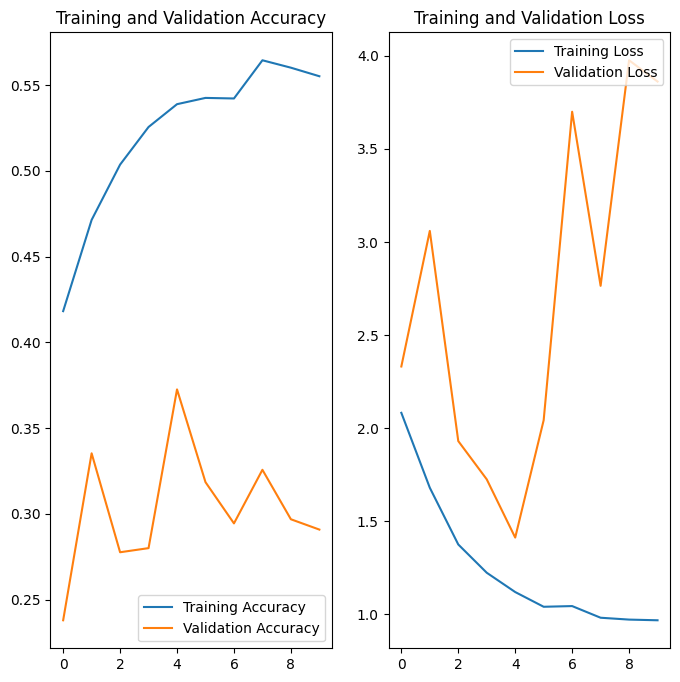

In [ ]:
plot_performance(10, history)

13/13 [==============================] - 3s 68ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

            cataract       1.00      0.02      0.04        90
diabetic_retinopathy       0.28      1.00      0.44       108
            glaucoma       0.00      0.00      0.00       105
              normal       0.35      0.06      0.10       104

            accuracy                           0.29       407
           macro avg       0.41      0.27      0.14       407
        weighted avg       0.39      0.29      0.15       407



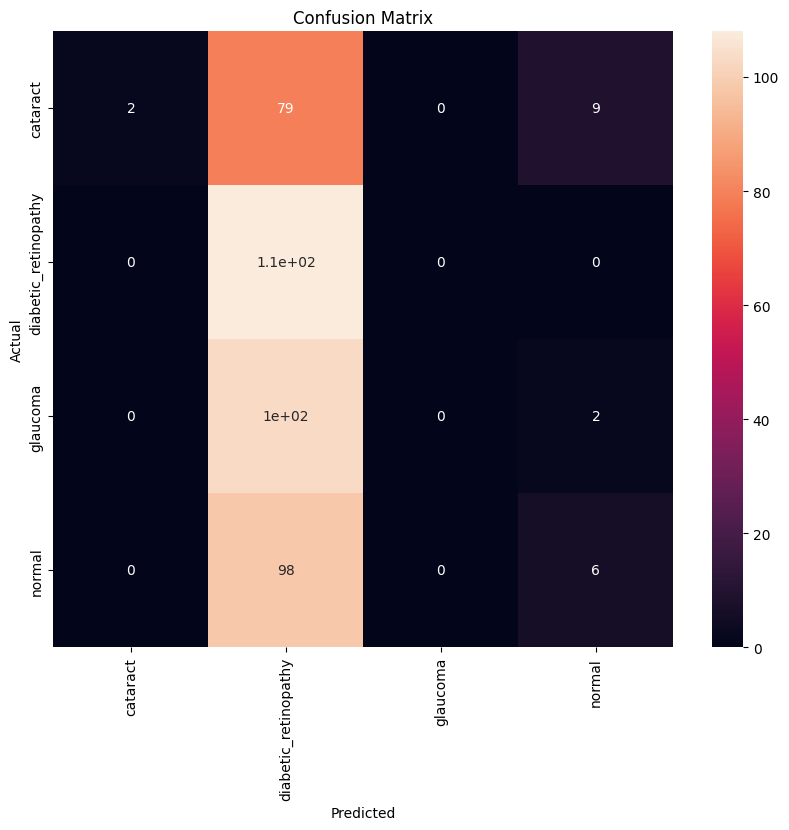

In [ ]:
evaluate_model(model)

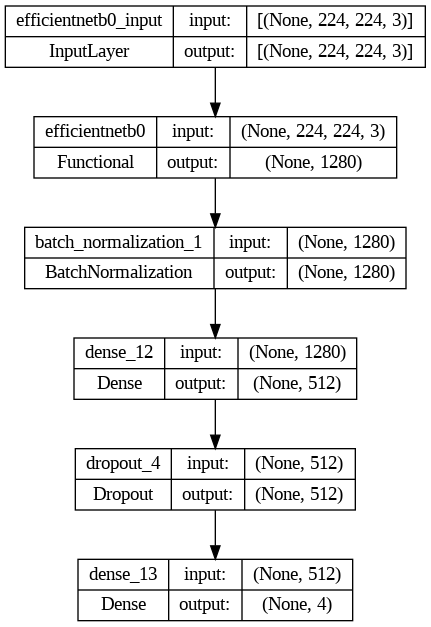

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='efficientnet.png', show_shapes=True)

VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
model = Sequential([
    vgg16,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation = 'relu'),
    Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
94/94 [==============================] - 69s 703ms/step - loss: 0.9017 - accuracy: 0.7015 - val_loss: 0.4743 - val_accuracy: 0.8041
Epoch 2/10
94/94 [==============================] - 56s 589ms/step - loss: 0.4118 - accuracy: 0.8271 - val_loss: 0.3482 - val_accuracy: 0.8690
Epoch 3/10
94/94 [==============================] - 67s 704ms/step - loss: 0.3548 - accuracy: 0.8521 - val_loss: 0.3855 - val_accuracy: 0.8401
Epoch 4/10
94/94 [==============================] - 67s 703ms/step - loss: 0.3400 - accuracy: 0.8644 - val_loss: 0.4245 - val_accuracy: 0.8245
Epoch 5/10
94/94 [==============================] - 67s 704ms/step - loss: 0.3193 - accuracy: 0.8733 - val_loss: 0.3587 - val_accuracy: 0.8546
Epoch 6/10
94/94 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8810

In [ ]:
plot_performance(10, history)

In [ ]:
evaluate_model(model)

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='vgg16.png', show_shapes=True)